# Formula 1 Grand Prix result prediction

## This project is aimed towards predicting the future F1 GP winners based on the drivers, constructors or both
### Things to keep in mind

Before begining the project we need to understand the history of F1 and the diffrent eras in which a certain driver or constructor dominated the whole grid. Here are some important eras of F1 after 2010.  

* 1994-2009 Schumacher (Scuderia Ferrari)
* 2007-2010 Alonso (Renault,Scuderia Ferrari)
* 2011-2013 Vettle (Redbull Racing)
* 2014-Present Hamilton (Mercedes-Benz)

F1 Constructors performance are largely dependent on the FIA techinical regulation for the season after the 2013 season new engine regulation were made (Hybrid era) Mercedes-Benz are most dominat team since followed bu Redbull Racing and Scuderia Ferrari. Rules are set to change for 2022 so whatever analysis made here will not apply for 2022 season and so far. only data after 2010 will be considered in the following analysis.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.preprocessing import StandardScaler,LabelEncoder,OneHotEncoder
from sklearn.model_selection import cross_val_score,StratifiedKFold,RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix,precision_score,f1_score,recall_score
plt.style.use('seaborn')

<ipython-input-1-7853432ede96>:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [ ]:
results = pd.read_csv(r'/content/results.csv')
races = pd.read_csv(r'/content/races.csv')
quali = pd.read_csv(r'/content/qualifying.csv')
drivers = pd.read_csv(r'/content/drivers.csv')
constructors = pd.read_csv(r'/content/constructors.csv')
circuit = pd.read_csv(r'/content/circuits.csv')

In [ ]:
df1 = pd.merge(races,results,how='inner',on=['raceId'])
df2 = pd.merge(df1,quali,how='inner',on=['raceId','driverId','constructorId'])
df3 = pd.merge(df2,drivers,how='inner',on=['driverId'])
df4 = pd.merge(df3,constructors,how='inner',on=['constructorId'])
df5 = pd.merge(df4,circuit,how='inner',on=['circuitId'])

<ipython-input-3-9fcb3f157dd4>:5: FutureWarning: Passing 'suffixes' which cause duplicate columns {'url_x'} in the result is deprecated and will raise a MergeError in a future version.
  df5 = pd.merge(df4,circuit,how='inner',on=['circuitId'])


In [ ]:
#drop the columns which are not important
data = df5.drop(['round','circuitId','time_x','url_x','resultId','driverId',
                 'constructorId','number_x','positionText','position_x',
                 'positionOrder','laps','time_y','rank',
                 'fastestLapTime','fastestLapSpeed','qualifyId','driverRef','number','code','url_y','circuitRef',
                 'location','lat','lng','alt','number_y','points','constructorRef','name_x','raceId','fastestLap','q2','q3','milliseconds','q1'],1)

<ipython-input-4-d4cbfc976d38>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data = df5.drop(['round','circuitId','time_x','url_x','resultId','driverId',


In [ ]:
#considering data points from 2010
data = data[data['year']>=2010]

In [ ]:
#rename the columns
data.rename(columns={'name':'GP_name','position_y':'position','grid':'quali_pos','name_y':'constructor','nationality_x':'driver_nationality','nationality_y':'constructor_nationality'},inplace=True)
data['driver'] = data['forename']+' '+data['surname']
data['date'] = pd.to_datetime(data['date'])
data['dob'] = pd.to_datetime(data['dob'])

In [ ]:
#creating a driver age parameter
data['age_at_gp_in_days'] = abs(data['dob']-data['date'])
data['age_at_gp_in_days'] = data['age_at_gp_in_days'].apply(lambda x: str(x).split(' ')[0])

In [ ]:
#Some of the constructors changed their name over the year so replacing old names with current name
data['constructor'] = data['constructor'].apply(lambda x: 'Aston Martin' if x in ['Force India', 'Racing Point'] else x)
data['constructor'] = data['constructor'].apply(lambda x: 'Alfa Romeo' if x == 'Sauber' else x)
data['constructor'] = data['constructor'].apply(lambda x: 'Alpine' if x in ['Lotus F1', 'Renault'] else x)
data['constructor'] = data['constructor'].apply(lambda x: 'AlphaTauri' if x == 'Toro Rosso' else x)

In [ ]:
data['driver_nationality'] = data['driver_nationality'].apply(lambda x: str(x)[:3])
data['constructor_nationality'] = data['constructor_nationality'].apply(lambda x: str(x)[:3])
data['country'] = data['country'].apply(lambda x: 'Bri' if x=='UK' else x)
data['country'] = data['country'].apply(lambda x: 'Ame' if x=='USA' else x)
data['country'] = data['country'].apply(lambda x: 'Fre' if x=='Fra' else x)
data['country'] = data['country'].apply(lambda x: str(x)[:3])
data['driver_home'] = data['driver_nationality'] == data['country']
data['constructor_home'] = data['constructor_nationality'] == data['country']
data['driver_home'] = data['driver_home'].apply(lambda x: int(x))
data['constructor_home'] = data['constructor_home'].apply(lambda x: int(x))

In [ ]:
#reasons for DNF(did not finish)
data['driver_dnf'] = data['statusId'].apply(lambda x: 1 if x in [3,4,20,29,31,41,68,73,81,97,82,104,107,130,137] else 0)
data['constructor_dnf'] = data['statusId'].apply(lambda x: 1 if x not in [3,4,20,29,31,41,68,73,81,97,82,104,107,130,137,1] else 0)
data.drop(['forename','surname'],1,inplace=True)

<ipython-input-10-25c0911fc15d>:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data.drop(['forename','surname'],1,inplace=True)


In [ ]:
font = {
    'family':'serif',
    'color':'black',
    'weight':'bold',
    'size':10
}

<ipython-input-12-4d3e09323f70>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dnf_by_driver = data.groupby('driver').sum()['driver_dnf']


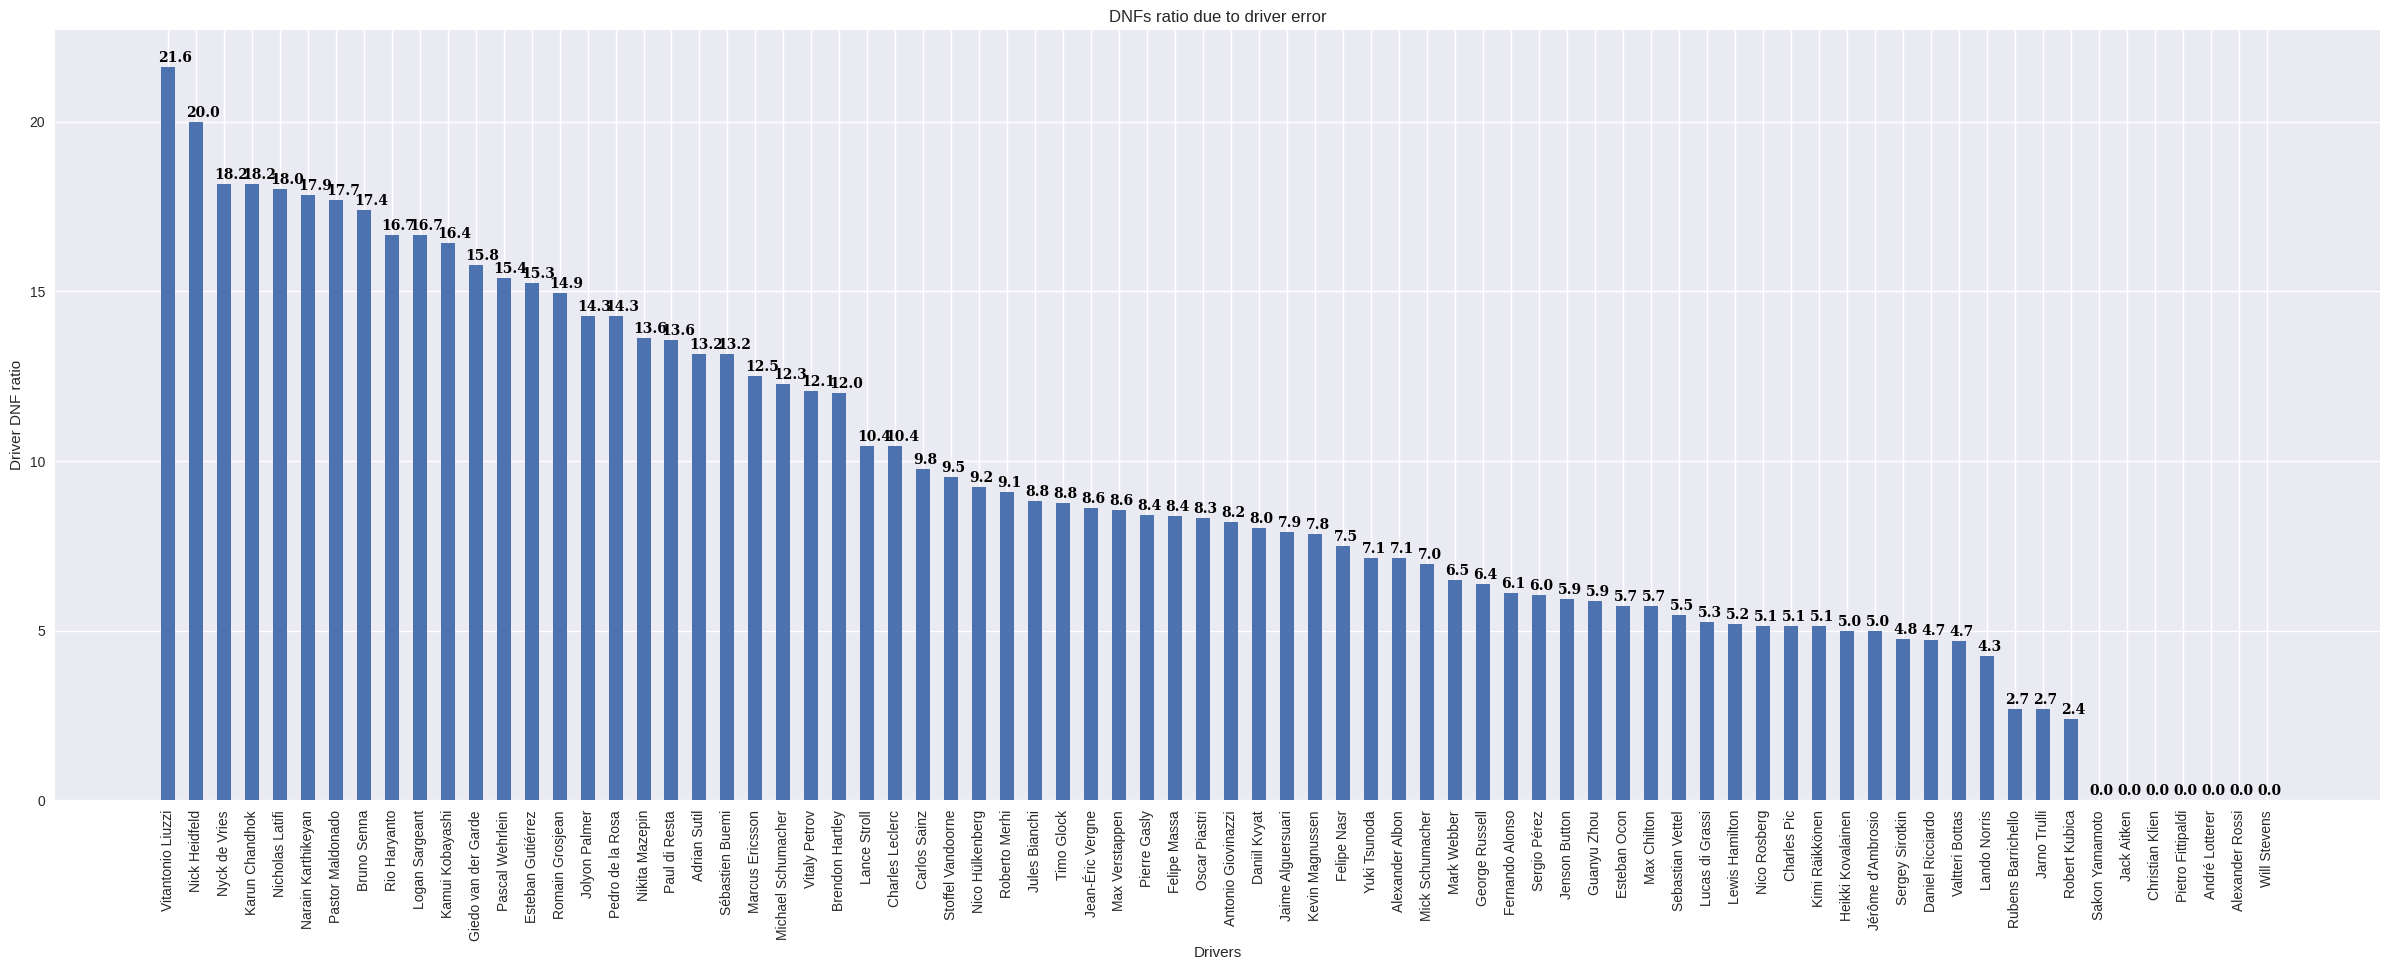

In [ ]:
dnf_by_driver = data.groupby('driver').sum()['driver_dnf']
driver_race_entered = data.groupby('driver').count()['driver_dnf']
driver_dnf_ratio = (dnf_by_driver*100/driver_race_entered).sort_values(ascending=False)
plt.figure(figsize=(30,10))
bars = plt.bar(x=driver_dnf_ratio.index,height=driver_dnf_ratio,align='center',width=0.5)
plt.xticks(rotation=90)
plt.xlabel('Drivers')
plt.ylabel('Driver DNF ratio')
plt.title('DNFs ratio due to driver error')
for bar in bars.patches:
    yval = bar.get_height()
    plt.text(bar.get_x()-0.1,yval+0.15,f'{round(yval,1)}',fontdict=font)
plt.show()

<ipython-input-13-aaa7af982bb9>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dnf_by_constructor = data.groupby('constructor').sum()['constructor_dnf']


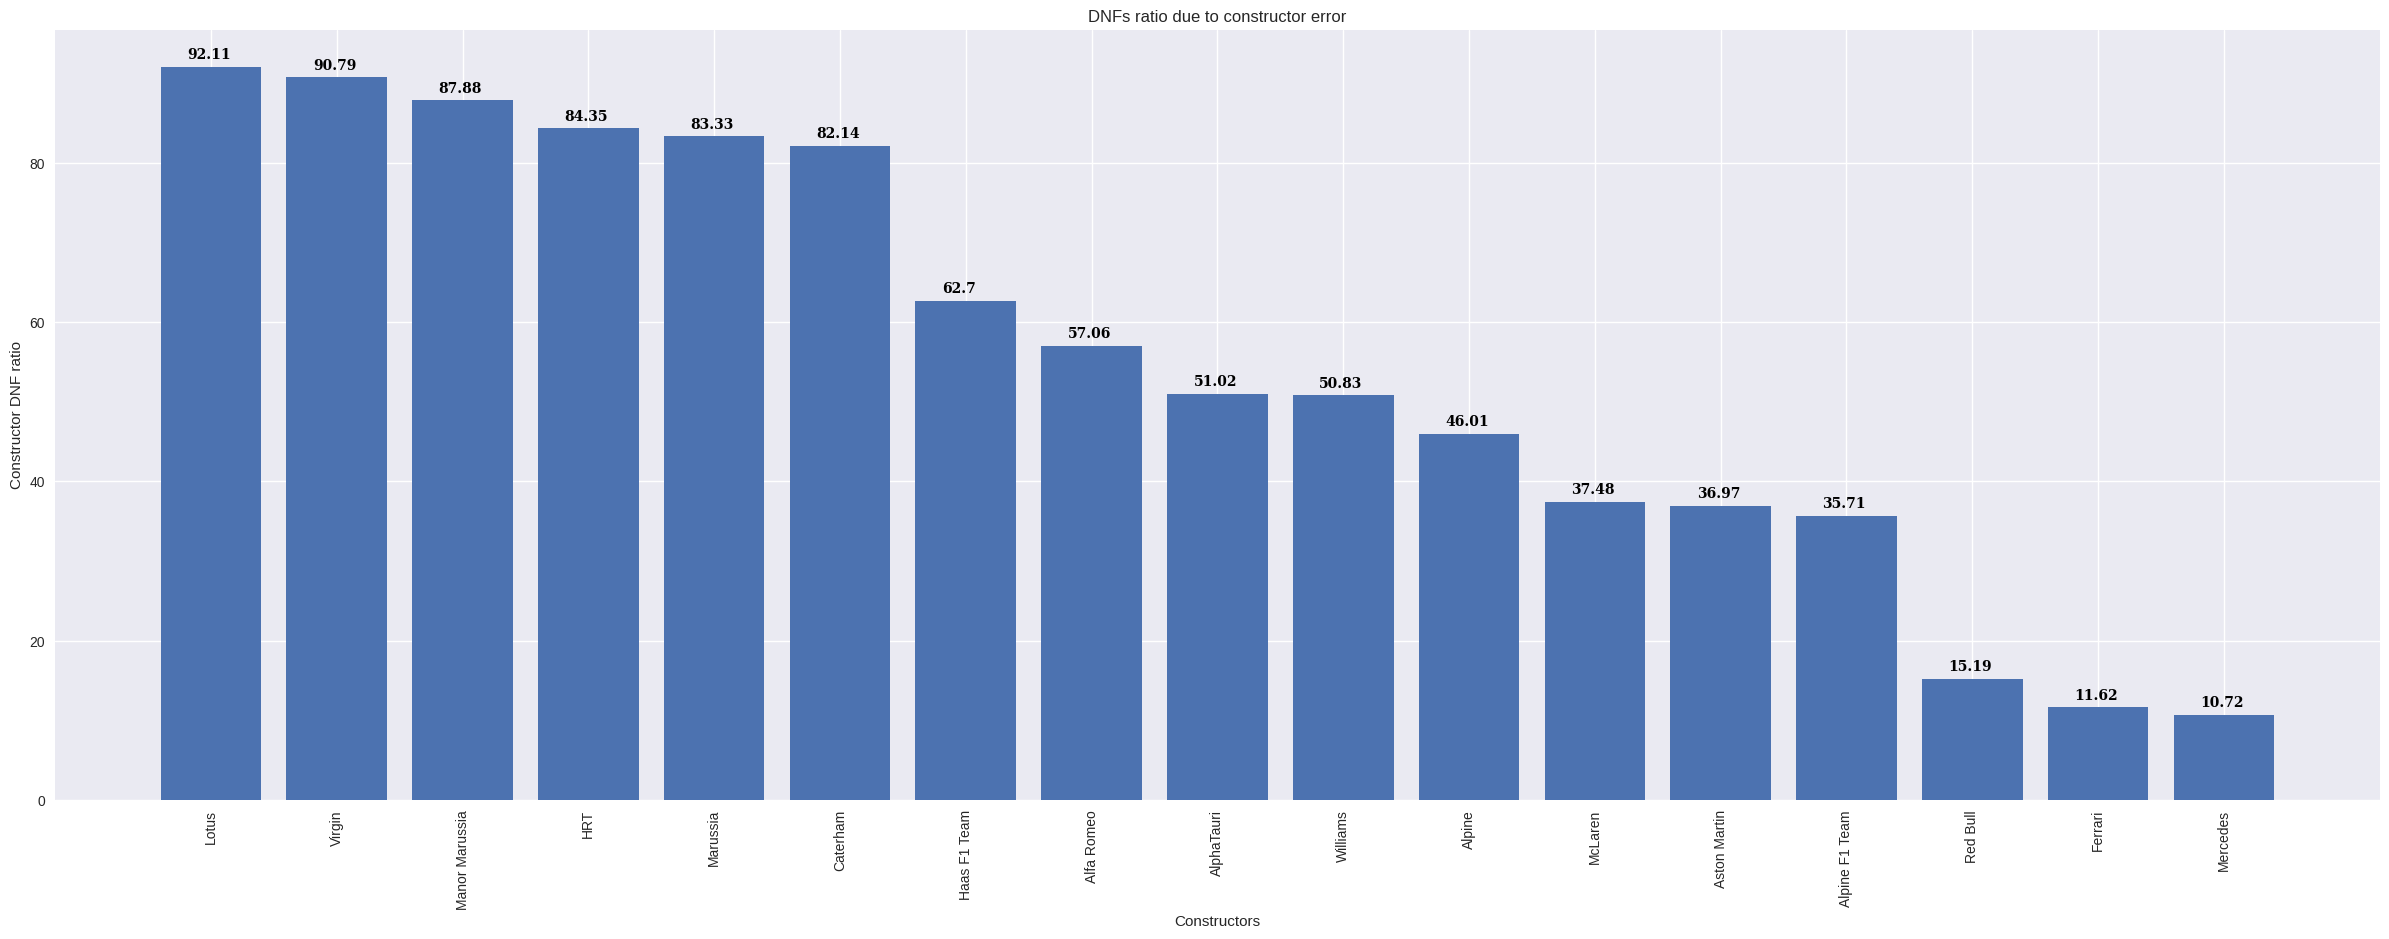

In [ ]:
dnf_by_constructor = data.groupby('constructor').sum()['constructor_dnf']
constructor_race_entered = data.groupby('constructor').count()['constructor_dnf']
constructor_dnf_ratio = (dnf_by_constructor*100/constructor_race_entered).sort_values(ascending=False)
plt.figure(figsize=(30,10))
bars = plt.bar(x=constructor_dnf_ratio.index,height=constructor_dnf_ratio,align='center',width=0.8)
plt.xticks(rotation=90)
plt.xlabel('Constructors')
plt.ylabel('Constructor DNF ratio')
plt.title('DNFs ratio due to constructor error')
for bar in bars.patches:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.21,yval+1,f'{round(yval,2)}',fontdict=font)
plt.show()

<ipython-input-14-dbb65a068dc6>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  total_home_races = data[data['driver_home']==1].groupby('driver').sum()['driver_home']


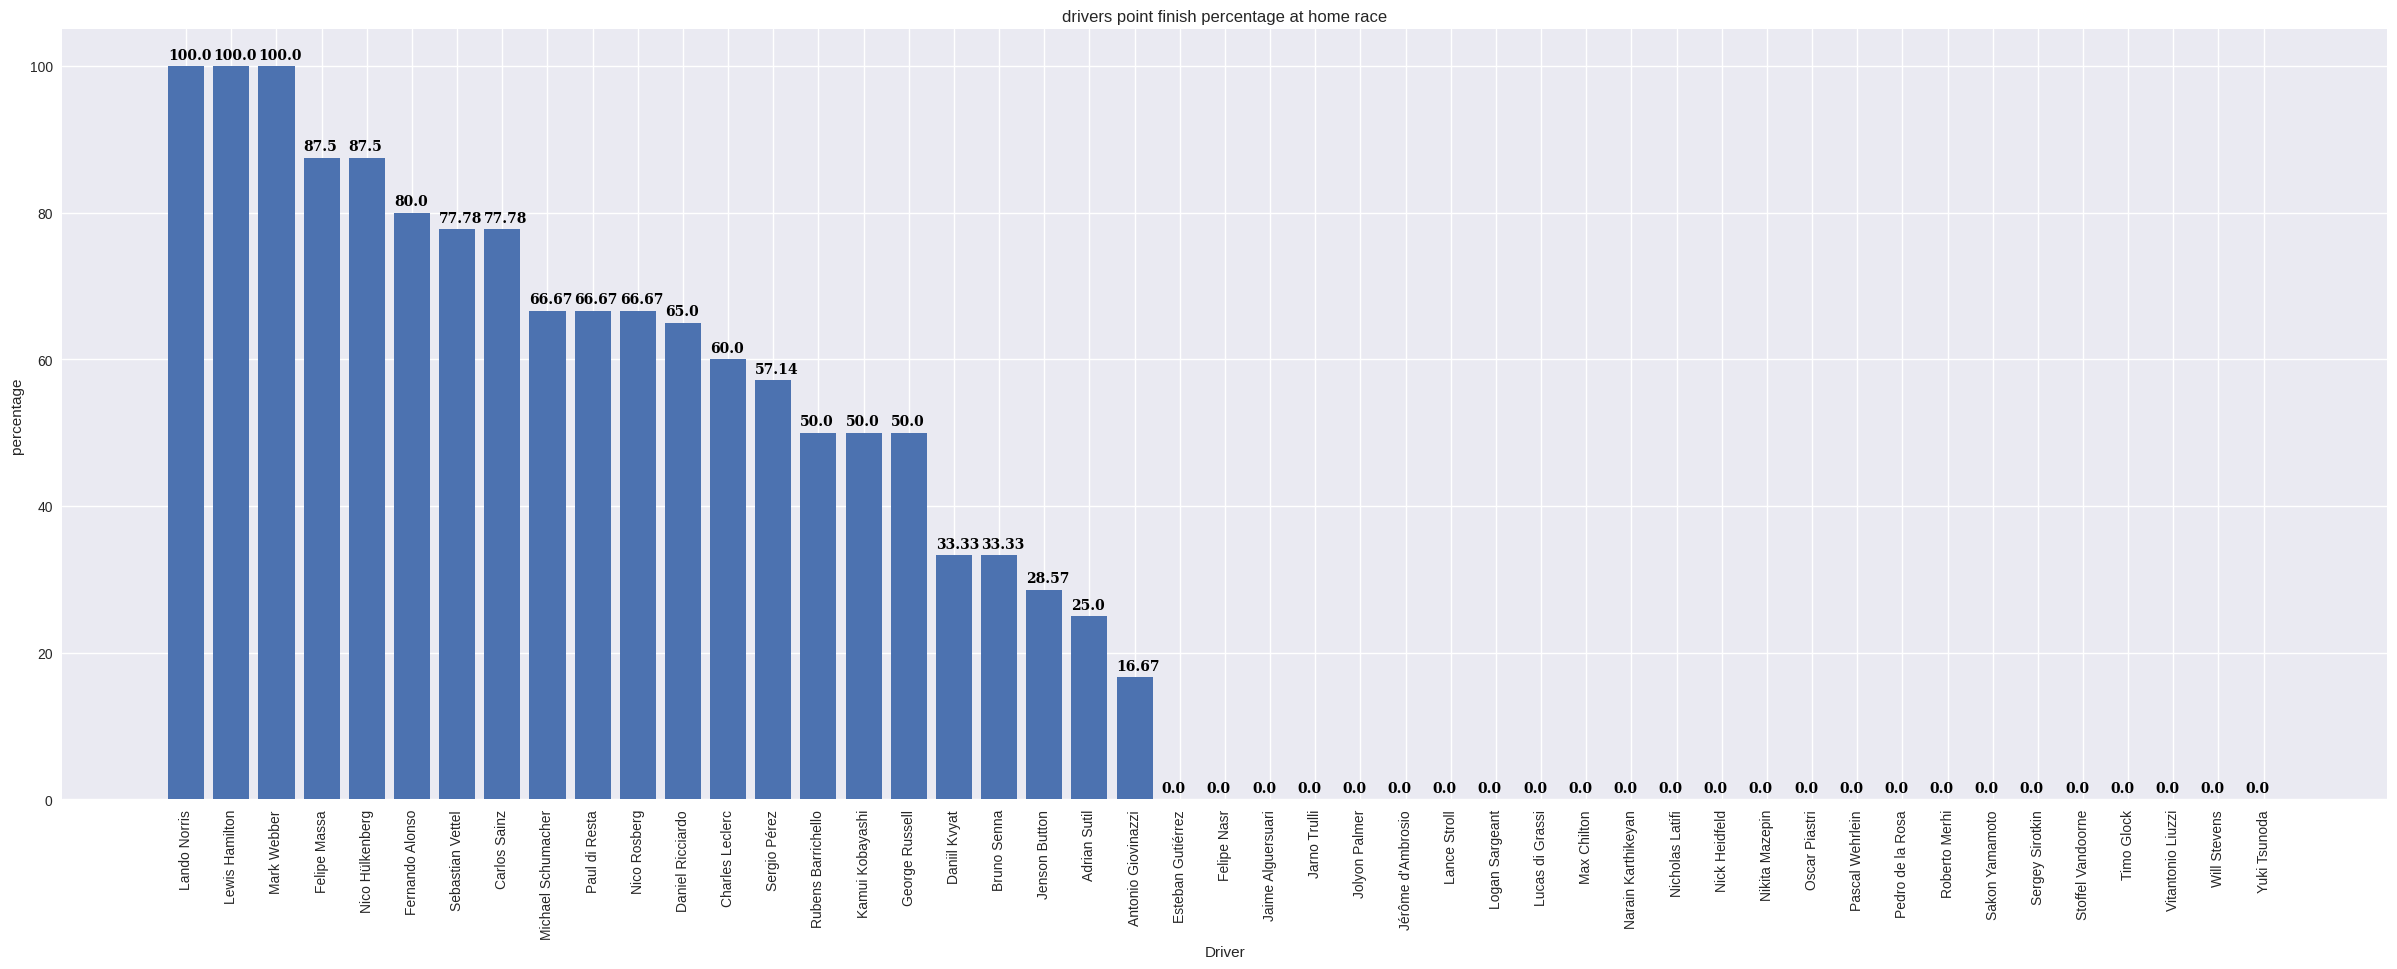

In [ ]:
driver_home_points_finish = data.loc[(data['position']<11)&(data['driver_home']==1)].groupby('driver').count()['position']
total_home_races = data[data['driver_home']==1].groupby('driver').sum()['driver_home']
driver_home_point_finish_ratio = (driver_home_points_finish*100/total_home_races).sort_values(ascending=False).fillna(0)
plt.figure(figsize=(30,10))
bars = plt.bar(x=driver_home_point_finish_ratio.index,height=driver_home_point_finish_ratio,align='center',width=0.8)
plt.xticks(rotation=90)
plt.xlabel('Driver')
plt.ylabel('percentage')
plt.title('drivers point finish percentage at home race')
for bar in bars.patches:
    yval = bar.get_height()
    plt.text(bar.get_x(),yval+1,f'{round(yval,2)}',fontdict=font)
plt.show()

<ipython-input-15-358900fe1adb>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  total_home_races = data[data['driver_home']==1].groupby('driver').sum()['driver_home']


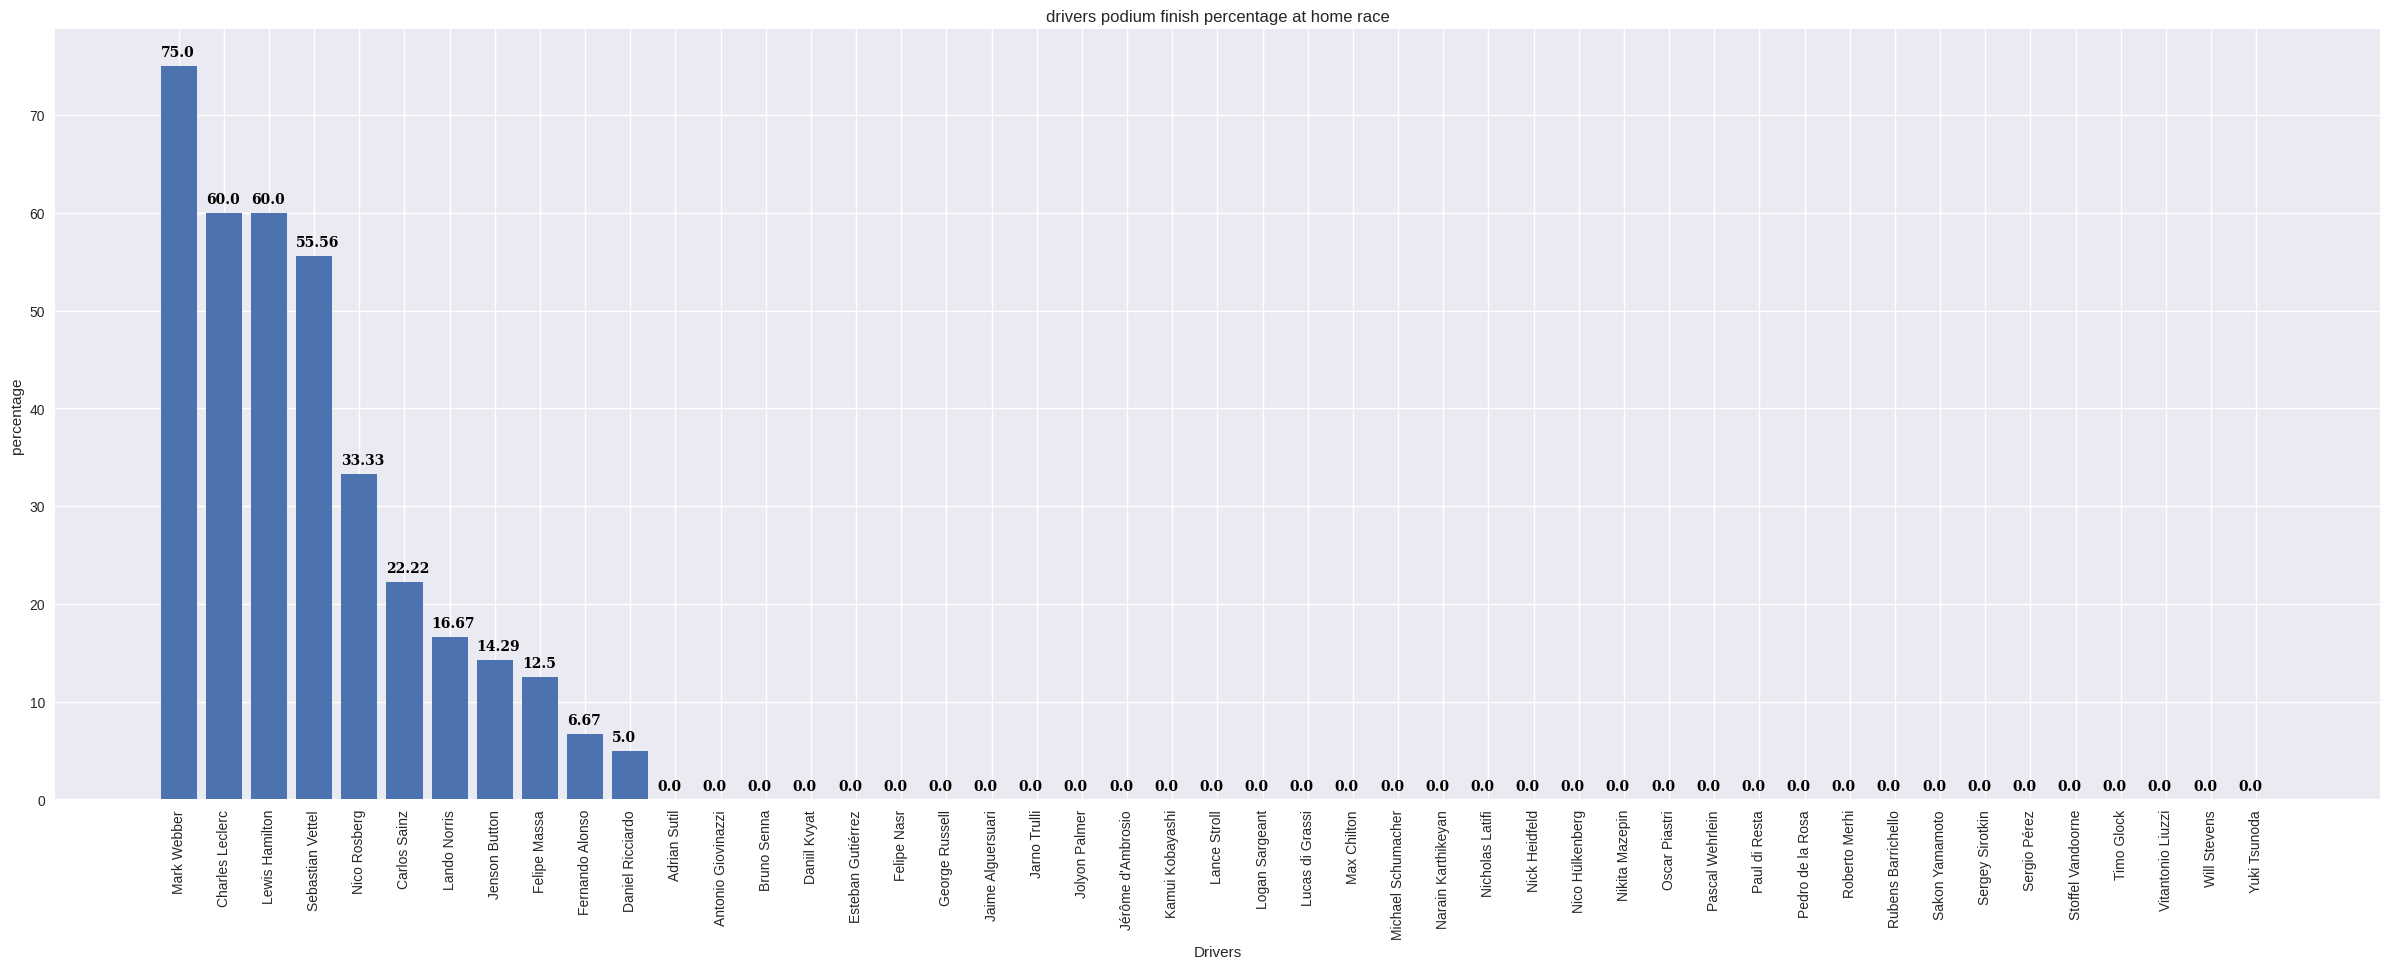

In [ ]:
driver_home_podium_finish = data.loc[(data['position']<4)&(data['driver_home']==1)].groupby('driver').count()['position']
total_home_races = data[data['driver_home']==1].groupby('driver').sum()['driver_home']
driver_home_podium_finish_ratio = (driver_home_podium_finish*100/total_home_races).sort_values(ascending=False).fillna(0)
plt.figure(figsize=(30,10))
bars = plt.bar(x=driver_home_podium_finish_ratio.index,height=driver_home_podium_finish_ratio,align='center',width=0.8)
plt.xticks(rotation=90)
plt.xlabel('Drivers')
plt.ylabel('percentage')
plt.title('drivers podium finish percentage at home race')
for bar in bars.patches:
    yval = bar.get_height()
    plt.text(bar.get_x(),yval+1,f'{round(yval,2)}',fontdict=font)
plt.show()

<ipython-input-16-02f13dddda80>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  total_home_races = data[data['constructor_home']==1].groupby('constructor').sum()['constructor_home']


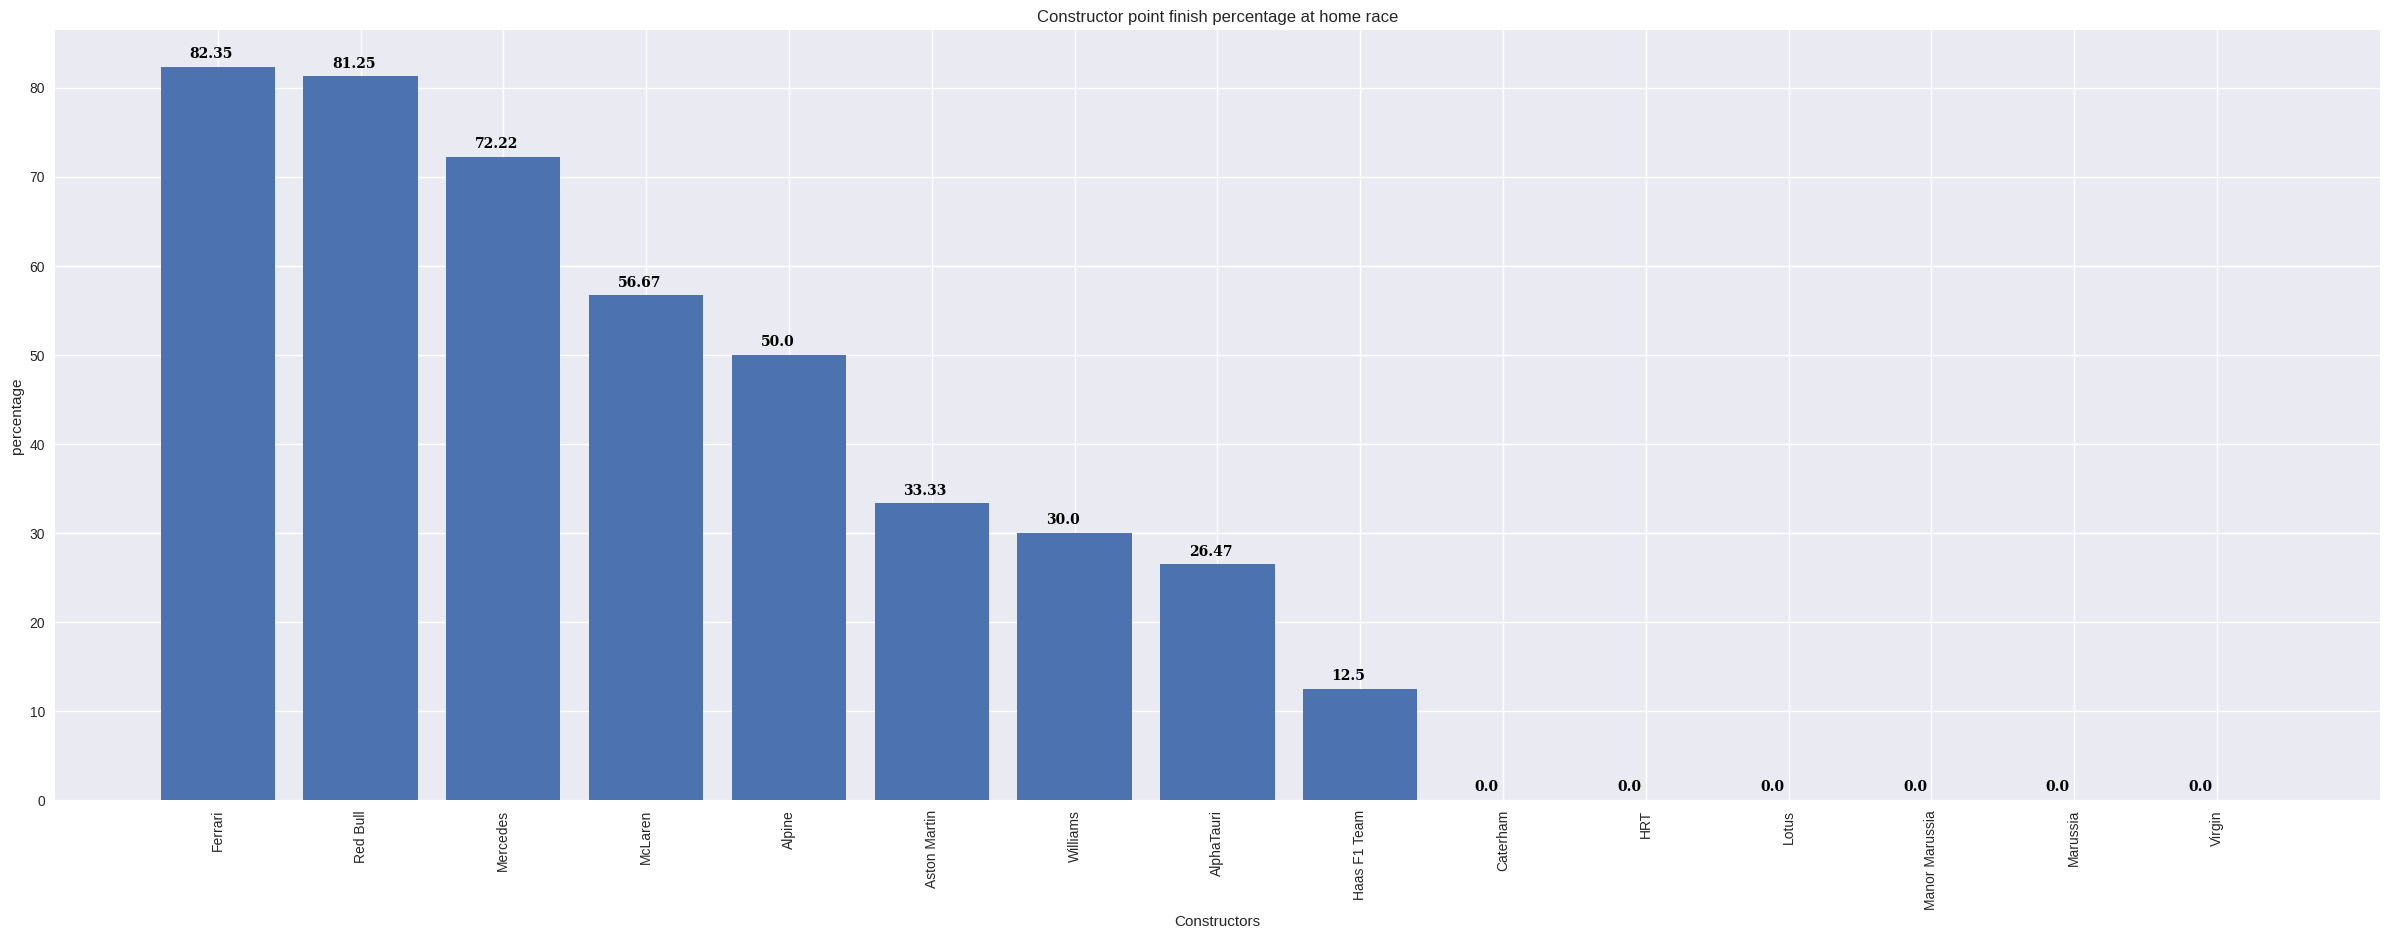

In [ ]:
constructor_home_points_finish = data.loc[(data['position']<11)&(data['constructor_home']==1)].groupby('constructor').count()['position']
total_home_races = data[data['constructor_home']==1].groupby('constructor').sum()['constructor_home']
constructor_home_point_finish_ratio = (constructor_home_points_finish*100/total_home_races).sort_values(ascending=False).fillna(0)
plt.figure(figsize=(30,10))
bars = plt.bar(x=constructor_home_point_finish_ratio.index,height=constructor_home_point_finish_ratio,align='center',width=0.8)
plt.xticks(rotation=90)
plt.xlabel('Constructors')
plt.ylabel('percentage')
plt.title('Constructor point finish percentage at home race')
for bar in bars.patches:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.2,yval+1,f'{round(yval,2)}',fontdict=font)
plt.show()

<ipython-input-17-ad25278bfa86>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  total_home_races = data[data['constructor_home']==1].groupby('constructor').sum()['constructor_home']


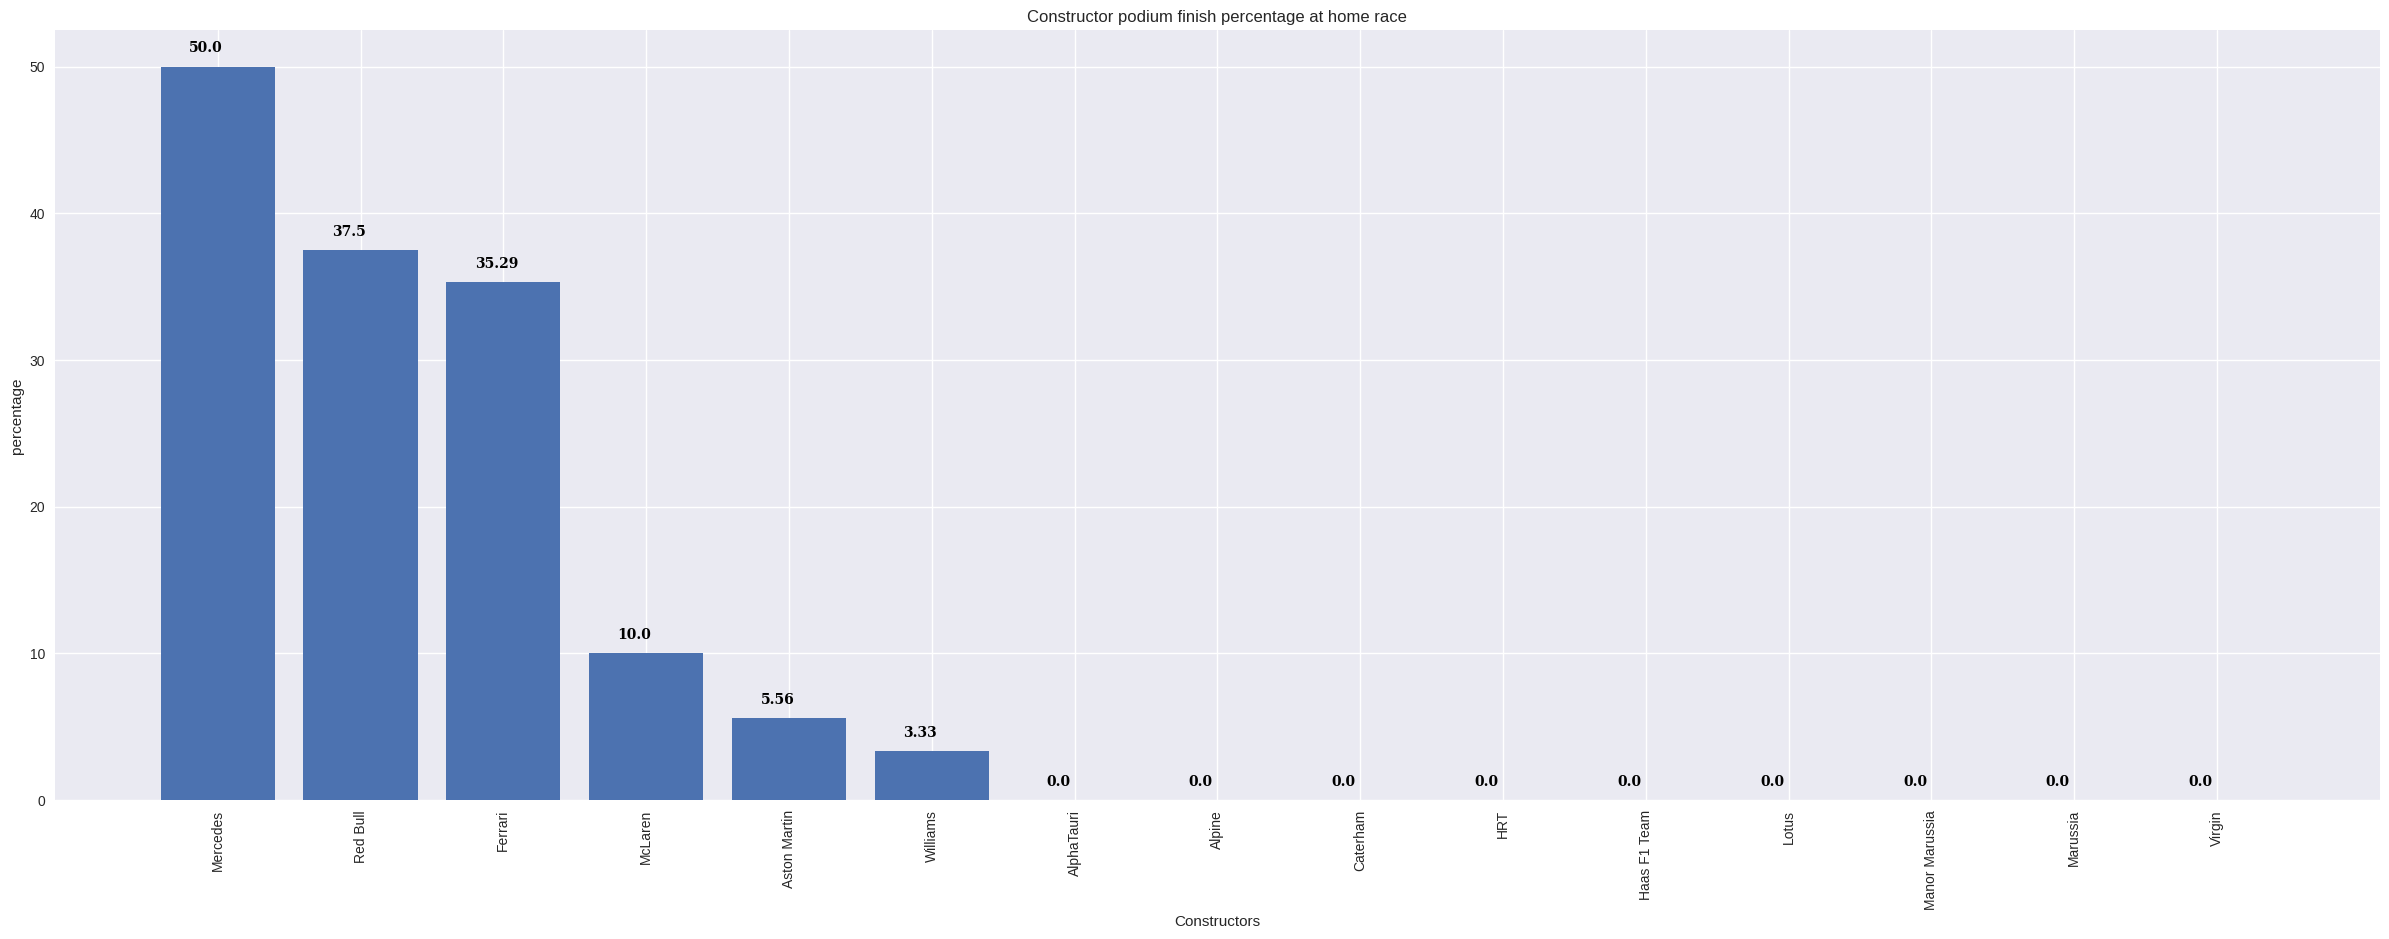

In [ ]:
constructor_home_points_finish = data.loc[(data['position']<4)&(data['constructor_home']==1)].groupby('constructor').count()['position']
total_home_races = data[data['constructor_home']==1].groupby('constructor').sum()['constructor_home']
constructor_home_point_finish_ratio = (constructor_home_points_finish*100/total_home_races).sort_values(ascending=False).fillna(0)
plt.figure(figsize=(30,10))
bars = plt.bar(x=constructor_home_point_finish_ratio.index,height=constructor_home_point_finish_ratio,align='center',width=0.8)
plt.xticks(rotation=90)
plt.xlabel('Constructors')
plt.ylabel('percentage')
plt.title('Constructor podium finish percentage at home race')
for bar in bars.patches:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.2,yval+1,f'{round(yval,2)}',fontdict=font)
plt.show()

In [ ]:
dnf_by_driver = data.groupby('driver').sum()['driver_dnf']
driver_race_entered = data.groupby('driver').count()['driver_dnf']
driver_dnf_ratio = (dnf_by_driver/driver_race_entered)
driver_confidence = 1-driver_dnf_ratio
driver_confidence_dict = dict(zip(driver_confidence.index,driver_confidence))

<ipython-input-18-7039cdcc8b4a>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dnf_by_driver = data.groupby('driver').sum()['driver_dnf']


In [ ]:
dnf_by_constructor = data.groupby('constructor').sum()['constructor_dnf']
constructor_race_entered = data.groupby('constructor').count()['constructor_dnf']
constructor_dnf_ratio = (dnf_by_constructor/constructor_race_entered)
constructor_relaiblity = 1-constructor_dnf_ratio
constructor_relaiblity_dict = dict(zip(constructor_relaiblity.index,constructor_relaiblity))

<ipython-input-19-f939a3081a60>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dnf_by_constructor = data.groupby('constructor').sum()['constructor_dnf']


In [ ]:
data['driver_confidence'] = data['driver'].apply(lambda x:driver_confidence_dict[x])
data['constructor_relaiblity'] = data['constructor'].apply(lambda x:constructor_relaiblity_dict[x])
#removing retired drivers and constructors
active_constructors = ['Alpine', 'Williams', 'McLaren', 'Ferrari', 'Mercedes',
                       'AlphaTauri', 'Aston Martin', 'Alfa Romeo', 'Red Bull',
                       'Haas F1 Team']
active_drivers = ['Daniel Ricciardo', 'Kevin Magnussen', 'Carlos Sainz',
                  'Valtteri Bottas', 'Lance Stroll', 'George Russell',
                  'Lando Norris', 'Oscar Piastri', 'Logan Sargeant',
                  'Charles Leclerc', 'Lewis Hamilton', 'Nico Hülkenberg ',
                  'Max Verstappen', 'Pierre Gasly', 'Alexander Albon',
                  'Sergio Pérez', 'Esteban Ocon', 'Fernando Alonso',
                  'Yuki Tsunoda','Zhou Guanyu']

data['active_driver'] = data['driver'].apply(lambda x: int(x in active_drivers))
data['active_constructor'] = data['constructor'].apply(lambda x: int(x in active_constructors))

### Model considering both drivers and constructors

In [ ]:
cleaned_data = data[['GP_name','quali_pos','constructor','driver','position','driver_confidence','constructor_relaiblity','active_driver','active_constructor','dob']]
cleaned_data = cleaned_data[(cleaned_data['active_driver']==1)&(cleaned_data['active_constructor']==1)]
cleaned_data.to_csv('cleaned_data.csv',index=False)

In [ ]:
def position_index(x):
    if x<4:
        return 1
    if x>10:
        return 3
    else :
        return 2

In [ ]:
sc  = StandardScaler()
le = LabelEncoder()
cleaned_data['GP_name'] = le.fit_transform(cleaned_data['GP_name'])
cleaned_data['constructor'] = le.fit_transform(cleaned_data['constructor'])
cleaned_data['driver'] = le.fit_transform(cleaned_data['driver'])
cleaned_data['GP_name'] = le.fit_transform(cleaned_data['GP_name'])
X = cleaned_data.drop(['position','active_driver','active_constructor'],1)
y = cleaned_data['position'].apply(lambda x: position_index(x))

<ipython-input-23-5dac68f5694f>:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = cleaned_data.drop(['position','active_driver','active_constructor'],1)


In [ ]:
X['year'] = X['dob'].dt.year
X['month'] = X['dob'].dt.month
X['day'] = X['dob'].dt.day
X = X.drop('dob', axis=1)

In [ ]:
print(X)

      GP_name  quali_pos  constructor  driver  driver_confidence  \
39          0         12            2       3           0.952790   
40          0         14            2       7           0.921569   
41          0          9            2       1           0.902299   
90          0         16            9      16           0.953052   
91          0         15            9      16           0.953052   
...       ...        ...          ...     ...                ...   
9796       22          6            7      16           0.953052   
9797       22         11            8      15           0.939516   
9798       22          7            8      12           0.914286   
9803       22          2            1      14           0.915966   
9804       22          8            1      17           0.928571   

      constructor_relaiblity  year  month  day  
39                  0.539906  1989      7    1  
40                  0.539906  1992     10    5  
41                  0.539906  1994  

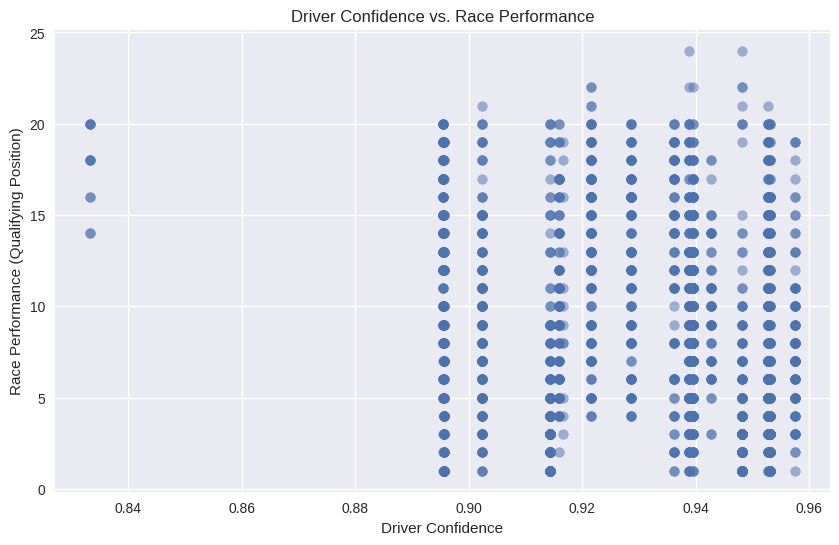

In [ ]:
# Filter the data to exclude outliers or data points with missing values
Filtered_data = X[(X['driver_confidence'] >= 0) & (X['quali_pos'] > 0)]
plt.figure(figsize=(10, 6))
plt.scatter(Filtered_data['driver_confidence'], Filtered_data['quali_pos'], alpha=0.5)
plt.title('Driver Confidence vs. Race Performance')
plt.xlabel('Driver Confidence')
plt.ylabel('Race Performance (Qualifying Position)')
plt.grid(True)
plt.show()

In [ ]:
#cross validation for diffrent models
models = [LogisticRegression(),DecisionTreeClassifier(),RandomForestClassifier(),SVC(),GaussianNB(),KNeighborsClassifier()]
names = ['LogisticRegression','DecisionTreeClassifier','RandomForestClassifier','SVC','GaussianNB','KNeighborsClassifier']
model_dict = dict(zip(models,names))
mean_results = []
results = []
name = []
for model in models:
    cv = StratifiedKFold(n_splits=10,random_state=None)
    result = cross_val_score(model,X,y,cv=cv,scoring='accuracy')
    mean_results.append(result.mean())
    results.append(result)
    name.append(model_dict[model])
    print(f'{model_dict[model]} : {result.mean()}')

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

LogisticRegression : 0.9075958856345885
DecisionTreeClassifier : 0.8891910739191073
RandomForestClassifier : 0.9201307531380755
SVC : 0.4180613668061367
GaussianNB : 0.7909431659693167
KNeighborsClassifier : 0.8616091352859134


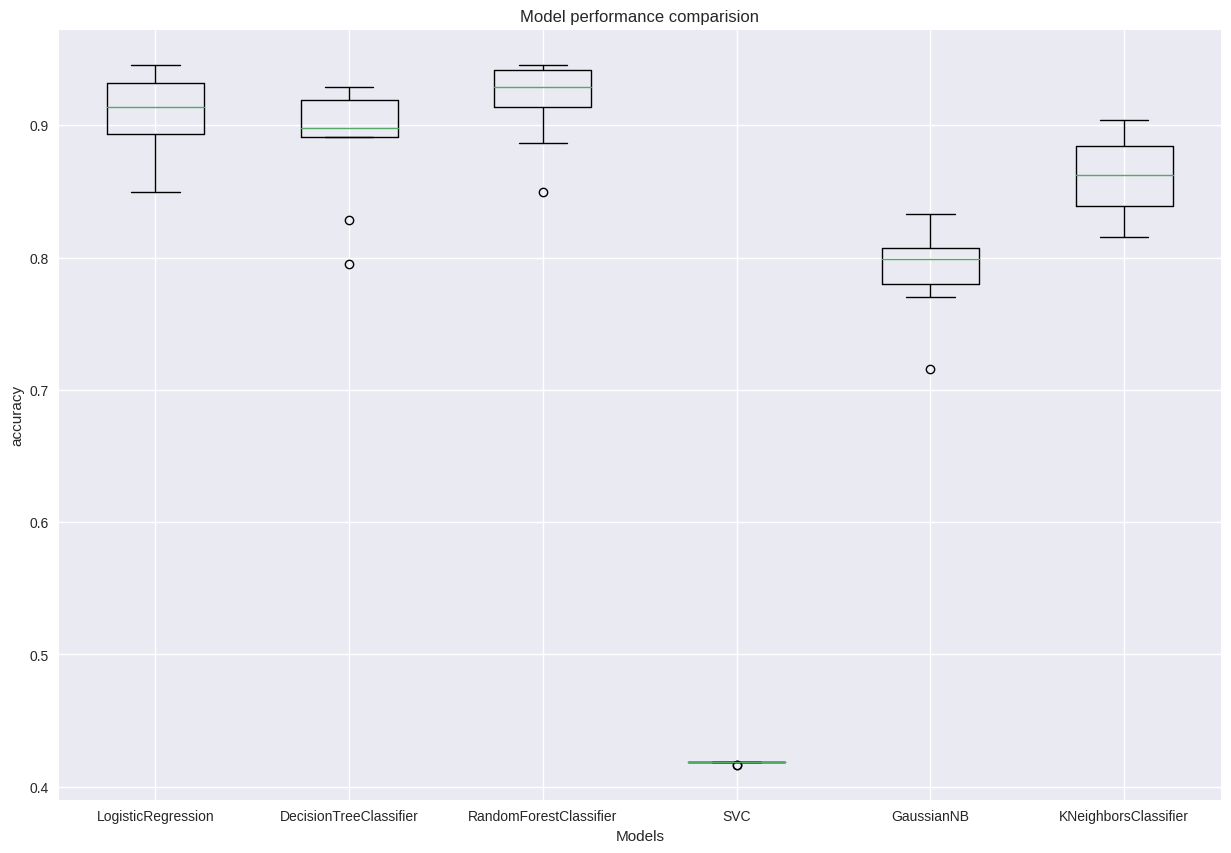

In [ ]:
plt.figure(figsize=(15,10))
plt.boxplot(x=results,labels=name)
plt.xlabel('Models')
plt.ylabel('accuracy')
plt.title('Model performance comparision')
plt.show()

### Model considering only drivers

In [ ]:
x_d= data[['GP_name','quali_pos','driver','age_at_gp_in_days','position','driver_confidence','active_driver']]

In [ ]:
x_d = x_d[x_d['active_driver']==1]

In [ ]:
sc  = StandardScaler()
le = LabelEncoder()
x_d['GP_name'] = le.fit_transform(x_d['GP_name'])
x_d['driver'] = le.fit_transform(x_d['driver'])
x_d['GP_name'] = le.fit_transform(x_d['GP_name'])
x_d['age_at_gp_in_days'] = sc.fit_transform(x_d[['age_at_gp_in_days']])
X_d = x_d.drop(['position','active_driver'],1)
y_d = x_d['position'].apply(lambda x: position_index(x))

<ipython-input-31-c31483ee1796>:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_d = x_d.drop(['position','active_driver'],1)


In [ ]:
#cross validation for diffrent models
models = [LogisticRegression(),DecisionTreeClassifier(),RandomForestClassifier(),SVC(),GaussianNB(),KNeighborsClassifier()]
names = ['LogisticRegression','DecisionTreeClassifier','RandomForestClassifier','SVC','GaussianNB','KNeighborsClassifier']
model_dict = dict(zip(models,names))
mean_results_dri = []
results_dri = []
name = []
for model in models:
    cv = StratifiedKFold(n_splits=6,random_state=None)
    result = cross_val_score(model,X_d,y_d,cv=cv,scoring='accuracy')
    mean_results_dri.append(result.mean())
    results_dri.append(result)
    name.append(model_dict[model])
    print(f'{model_dict[model]} : {result.mean()}')

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

LogisticRegression : 0.9143714888964296
DecisionTreeClassifier : 0.8910106322814162
RandomForestClassifier : 0.9278550691852354
SVC : 0.9219036308109944
GaussianNB : 0.8727510085586094
KNeighborsClassifier : 0.8945679221807489


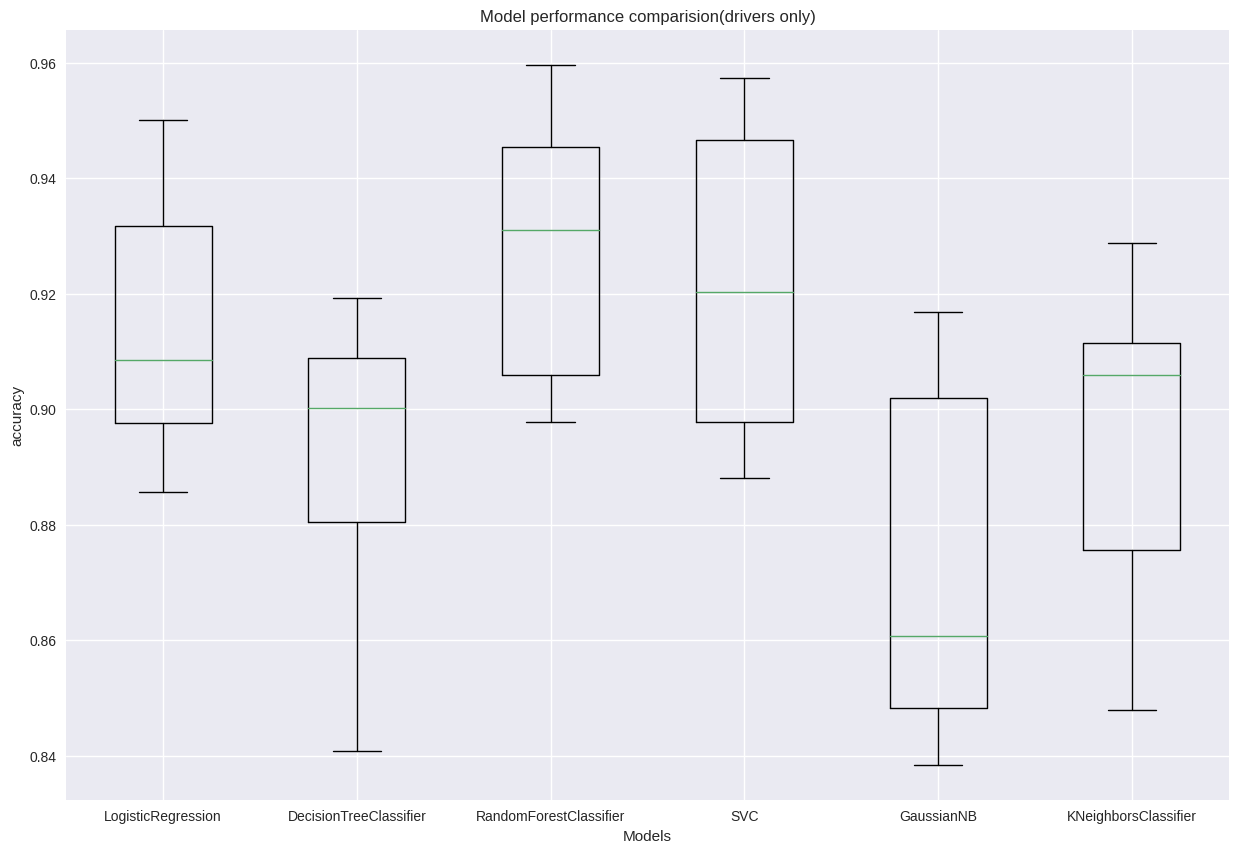

In [ ]:
plt.figure(figsize=(15,10))
plt.boxplot(x=results_dri,labels=name)
plt.xlabel('Models')
plt.ylabel('accuracy')
plt.title('Model performance comparision(drivers only)')
plt.show()

### Model considering only constructor

In [ ]:
x_c = data[['GP_name','quali_pos','constructor','position','constructor_relaiblity','active_constructor']]

In [ ]:
x_c = x_c[x_c['active_constructor']==1]

In [ ]:
sc  = StandardScaler()
le = LabelEncoder()
x_c['GP_name'] = le.fit_transform(x_c['GP_name'])
x_c['constructor'] = le.fit_transform(x_c['constructor'])
X_c = x_c.drop(['position','active_constructor'],1)
y_c = x_c['position'].apply(lambda x: position_index(x))

<ipython-input-36-239536a0f4ea>:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_c = x_c.drop(['position','active_constructor'],1)


In [ ]:
#cross validation for diffrent models
models = [LogisticRegression(),DecisionTreeClassifier(),RandomForestClassifier(),SVC(),GaussianNB(),KNeighborsClassifier()]
names = ['LogisticRegression','DecisionTreeClassifier','RandomForestClassifier','SVC','GaussianNB','KNeighborsClassifier']
model_dict = dict(zip(models,names))
mean_results_const = []
results_const = []
name = []
for model in models:
    cv = StratifiedKFold(n_splits=10,random_state=None)
    result = cross_val_score(model,X_c,y_c,cv=cv,scoring='accuracy')
    mean_results_const.append(result.mean())
    results_const.append(result)
    name.append(model_dict[model])
    print(f'{model_dict[model]} : {result.mean()}')

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

LogisticRegression : 0.9165651782569562
DecisionTreeClassifier : 0.9021355613822252
RandomForestClassifier : 0.9252670919265841
SVC : 0.9418706218447932
GaussianNB : 0.8386706061910539
KNeighborsClassifier : 0.919532735882284


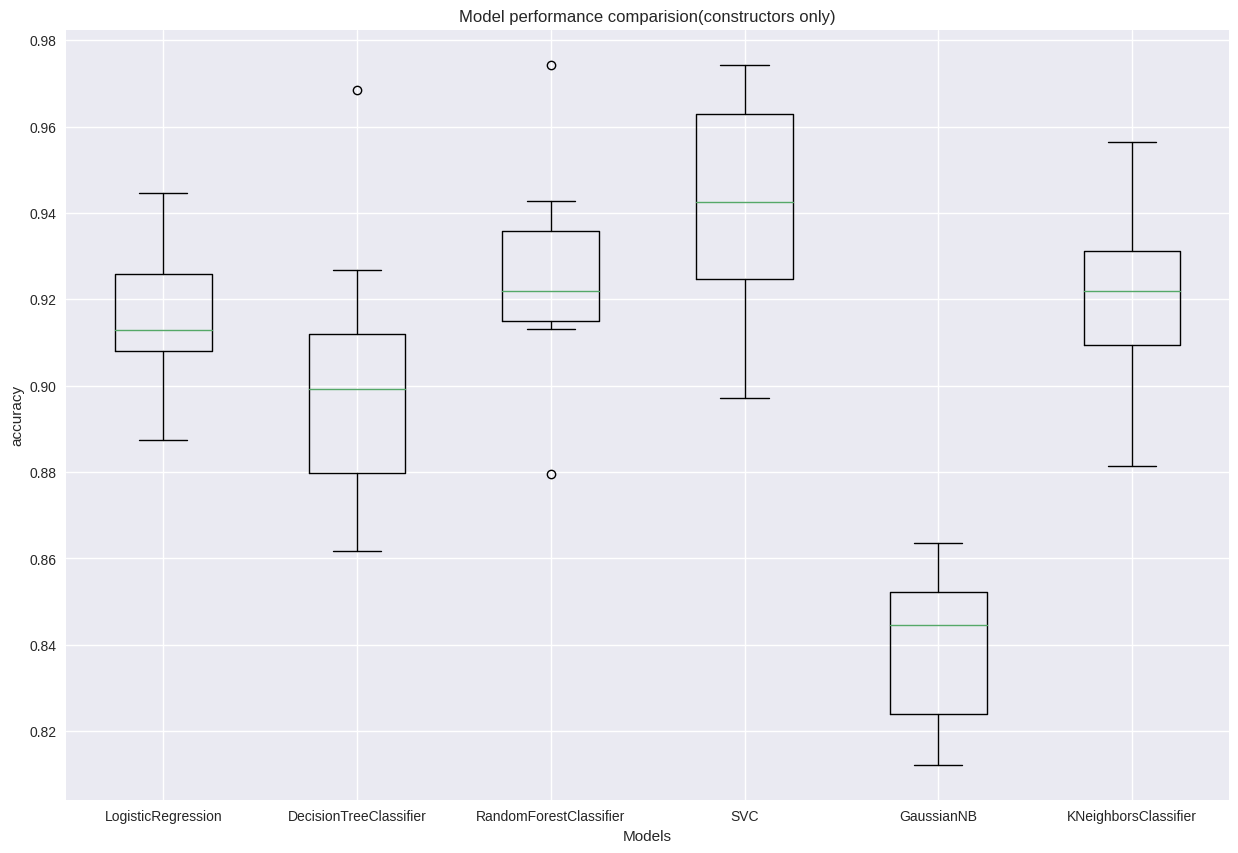

In [ ]:
plt.figure(figsize=(15,10))
plt.boxplot(x=results_const,labels=name)
plt.xlabel('Models')
plt.ylabel('accuracy')
plt.title('Model performance comparision(constructors only)')
plt.show()

#### lets see mean score of our three assumptions

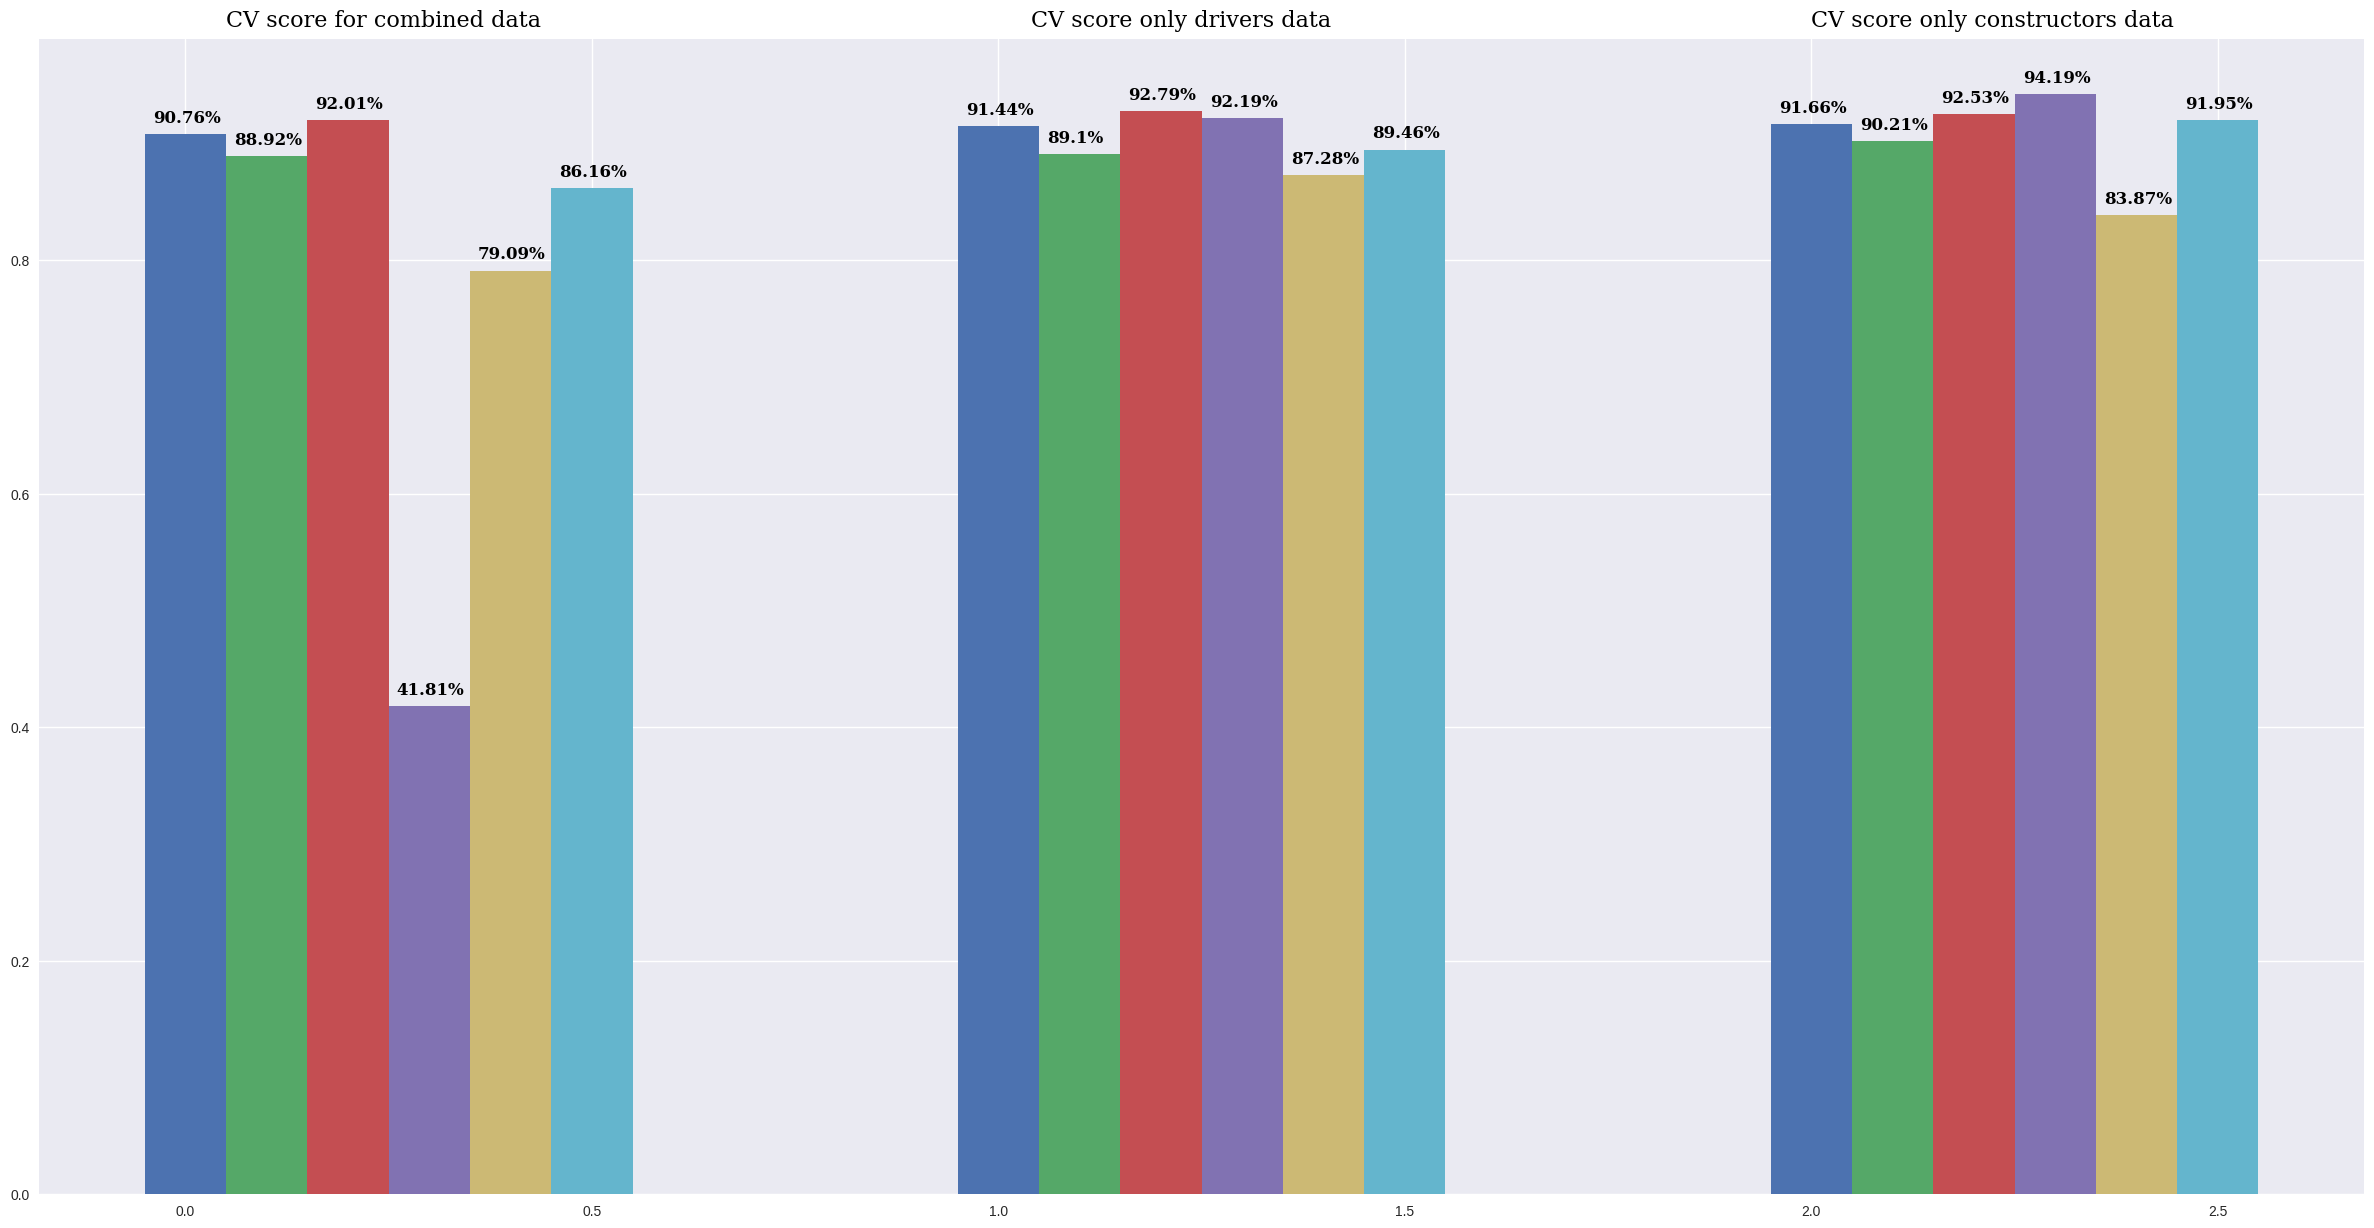

In [ ]:
lr = [mean_results[0],mean_results_dri[0],mean_results_const[0]]
dtc = [mean_results[1],mean_results_dri[1],mean_results_const[1]]
rfc = [mean_results[2],mean_results_dri[2],mean_results_const[2]]
svc = [mean_results[3],mean_results_dri[3],mean_results_const[3]]
gnb = [mean_results[4],mean_results_dri[4],mean_results_const[4]]
knn = [mean_results[5],mean_results_dri[5],mean_results_const[5]]
font1 = {
    'family':'serif',
    'color':'black',
    'weight':'normal',
    'size':16
}
font2 = {
    'family':'serif',
    'color':'black',
    'weight':'bold',
    'size':12
}
x_ax = np.arange(3)
plt.figure(figsize=(30,15))
bar1 = plt.bar(x_ax,lr,width=0.1,align='center')
bar2 = plt.bar(x_ax+0.1,dtc,width=0.1,align='center')
bar3 = plt.bar(x_ax+0.2,rfc,width=0.1,align='center')
bar4 = plt.bar(x_ax+0.3,svc,width=0.1,align='center')
bar5 = plt.bar(x_ax+0.4,gnb,width=0.1,align='center')
bar6 = plt.bar(x_ax+0.5,knn,width=0.1,align='center')
plt.text(0.05,1,'CV score for combined data',fontdict=font1)
plt.text(1.04,1,'CV score only drivers data',fontdict=font1)
plt.text(2,1,'CV score only constructors data',fontdict=font1)
for bar in bar1.patches:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.01,yval+0.01,f'{round(yval*100,2)}%',fontdict=font2)
for bar in bar2.patches:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.01,yval+0.01,f'{round(yval*100,2)}%',fontdict=font2)
for bar in bar3.patches:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.01,yval+0.01,f'{round(yval*100,2)}%',fontdict=font2)
for bar in bar4.patches:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.01,yval+0.01,f'{round(yval*100,2)}%',fontdict=font2)
for bar in bar5.patches:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.01,yval+0.01,f'{round(yval*100,2)}%',fontdict=font2)
for bar in bar6.patches:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.01,yval+0.01,f'{round(yval*100,2)}%',fontdict=font2)
plt.show()

In [ ]:
n_estimators = [int(x) for x in np.linspace(start=200,stop=2000,num=10)]
max_features = ['auto','sqrt']
max_depth = [int(x) for x in np.linspace(10,110,num=11)]
min_samples_split = [2,5,8,10,15,20]
min_samples_leaf = [1,2,4,6,8,10]
bootstrap = [True,False]

random_parms = {
    'n_estimators':n_estimators,
    'max_features':max_features,
    'max_depth':max_depth,
    'min_samples_split':min_samples_split,
    'min_samples_leaf':min_samples_leaf,
    'bootstrap':bootstrap
                }

In [ ]:
rf_rand = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator=rf_rand,param_distributions=random_parms,n_iter=50,cv=10,verbose=2,n_jobs=-1)
rf_random.fit(X,y)
rf_random.best_params_

Fitting 10 folds for each of 50 candidates, totalling 500 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


{'n_estimators': 400,
 'min_samples_split': 5,
 'min_samples_leaf': 6,
 'max_features': 'auto',
 'max_depth': 60,
 'bootstrap': False}

In [ ]:
rf = RandomForestClassifier(n_estimators=1600,min_samples_split=20,min_samples_leaf=1,max_features='sqrt',max_depth=90,bootstrap=True)
kf = StratifiedKFold(n_splits=10,random_state=None,shuffle=False)
for train_index,test_index in kf.split(X,y):
    X_train,X_test = X.iloc[train_index],X.iloc[test_index]
    y_train,y_test = y.iloc[train_index],y.iloc[test_index]

In [ ]:
rf.fit(X_train,y_train)
y_pred_rf = rf.predict(X_test)
cnf_mat_rf = confusion_matrix(y_test,y_pred_rf)
cnf_mat_rf = cnf_mat_rf/cnf_mat_rf.sum()

In [ ]:
svc = SVC()
svc.fit(X_train,y_train)
y_pred = svc.predict(X_test)
svc.fit(X_train,y_train)
y_pred_svc = svc.predict(X_test)
cnf_mat_svc = confusion_matrix(y_test,y_pred)
cnf_mat_svc = cnf_mat_svc/cnf_mat_svc.sum()

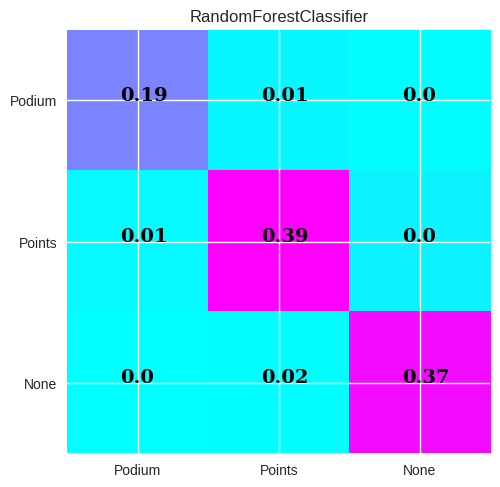

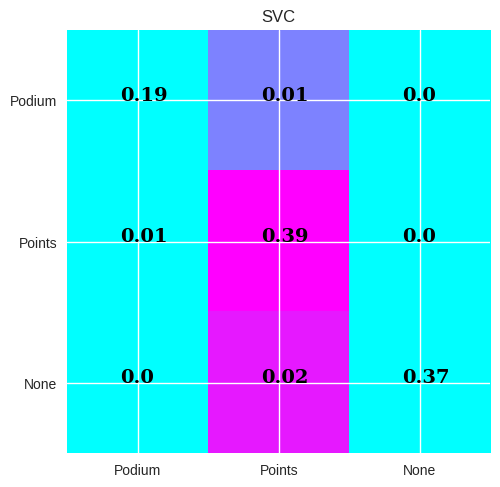

In [ ]:
font3 = {
    'family':'serif',
    'color':'black',
    'weight':'bold',
    'size':14
}
fig1,ax1 = plt.subplots()
fig2,ax2 = plt.subplots()
ax1.set_xticks(np.arange(3))
ax1.set_yticks(np.arange(3))
ax1.set_xticklabels(['Podium','Points','None'])
ax1.set_yticklabels(['Podium','Points','None'])
ax1.set_title('RandomForestClassifier')
im_rf = ax1.imshow(cnf_mat_rf,cmap='cool')
for i in range(3):
    for j in range(3):
            ax1.text(i-0.125,j,round(cnf_mat_rf[i,j],2),fontdict=font3)

ax2.set_xticks(np.arange(3))
ax2.set_yticks(np.arange(3))
ax2.set_xticklabels(['Podium','Points','None'])
ax2.set_yticklabels(['Podium','Points','None'])
ax2.set_title('SVC')
im_svc = ax2.imshow(cnf_mat_svc,cmap='cool')
for i in range(3):
    for j in range(3):
            ax2.text(i-0.125,j,round(cnf_mat_rf[i,j],2),fontdict=font3)

In [ ]:
rf_pression = precision_score(y_test, y_pred_rf, average='macro')
rf_f1 = f1_score(y_test,y_pred_rf,average='macro')
rf_recall = recall_score(y_test,y_pred_rf,average='macro')
svc_pression = precision_score(y_test, y_pred_svc, average='micro')
svc_f1 = f1_score(y_test,y_pred_svc,average='macro')
svc_recall = recall_score(y_test,y_pred_svc,average='macro')
metrics_dict ={
    'RandomForestClassifier':{'precision_score':rf_pression,'f1_score':rf_f1,'recall_score':rf_recall},
    'SVC':{'precision_score':svc_pression,'f1_score':svc_f1,'recall_score':svc_recall}
}
metrics_df = pd.DataFrame(metrics_dict)
metrics_df

,RandomForestClassifier,SVC
precision_score,0.951017,0.418410
f1_score,0.947942,0.196657
recall_score,0.945752,0.333333


# **Predictor**

In [ ]:
from pickle import load
import pickle
from sklearn.preprocessing import LabelEncoder

In [ ]:
driver_dict = pickle.load(open('driver_dict','rb'))
constructor_dict = pickle.load(open('consructor_dict','rb'))
clf = pickle.load(open('RandomForestClassifier.pkl','rb'))
data = pd.read_csv('cleaned_data.csv')
y_dict = {1:'Podium Finish',
          2:'Points Finish',
          3:'No Points Finish'
        }

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.23.0 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.23.0 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [ ]:
le_d = LabelEncoder()
le_d.fit(data[['driver']])
le_c = LabelEncoder()
le_c.fit(data[['constructor']])
le_gp = LabelEncoder()
le_gp.fit(data[['GP_name']])

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LabelEncoder()

In [ ]:
def pred(driver,constructor,quali,circuit):
    gp = le_gp.fit_transform([circuit]).max()
    quali_pos = quali
    constructor_enc = le_c.transform([constructor]).max()
    driver_enc = le_d.transform([driver]).max()
    driver_confidence = driver_dict[driver].max()
    constructor_relaiablity = constructor_dict[constructor].max()
    prediction = clf.predict([[gp,quali_pos,constructor_enc,driver_enc,driver_confidence,constructor_relaiablity]]).max()

    return y_dict[prediction]

In [ ]:
print(pred('Max Verstappen', 'Red Bull', '2', 'Silverstone Circuit'))

Podium Finish
